# INITIALIZATION

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils.mango import Mango

ModuleNotFoundError: No module named 'utils.abstraction'

In [4]:
import gymnasium as gym
from gym.spaces import Discrete, Box

# Environment

In [13]:
import gym

class Environment():
    def __init__(self, size=(8,8)):
        self.max_x,self.max_y = size
        self.reset()
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=size)
    
    def reset(self):
        self.x, self.y = np.random.randint(self.max_x),np.random.randint(self.max_y)
        self.path = [(self.x, self.y)]
        return self.get_state(), "info"
    
    def get_state(self):
        state = torch.zeros((self.max_x,self.max_y))
        state[self.x,self.y] = 1
        return torch.Tensor(state)
        
    def step(self,action):
        if action == 0:
            self.x = min((max((self.x+1, 0)),self.max_x-1))
        if action == 1:
            self.y = min((max((self.y+1, 0)),self.max_y-1))
        if action == 2:
            self.x = min((max((self.x-1, 0)),self.max_x-1))
        if action == 3:
            self.y = min((max((self.y-1, 0)),self.max_y-1))
        self.path.append((self.x,self.y))
        return self.get_state(), 0, "terminated", "truncated"
    
    def render(self):
        plt.imshow(self.get_state())
        for (x0,y0),(x1,y1) in zip(self.path,self.path[1:]):
            plt.plot((y0,y1),(x0,x1),"-r")
        x0,y0 = self.path[0]
        plt.plot(y0,x0,"xr")

# Abstractor

In [14]:
def ZoomOutAbstraction(reduction):
    class Abstraction(AbstractionFunction):
        def __init__(self, input_state_space):
            self.output_state_space = gym.spaces.Box(
                low=0, high=1, 
                shape=tuple(d//k for d,k in zip(input_state_space.shape, reduction))
            )
            self.k=reduction
            
        def abstract(self, state):
            kx,ky = self.k
            state_prime = torch.zeros(((state.shape[0]//kx,state.shape[1]//ky)))
            for x in range(state_prime.shape[0]):
                for y in range(state_prime.shape[1]):
                    state_prime[x,y] = torch.sum(state[kx*x:kx*x+kx,ky*y:ky*y+ky])
            return state_prime
    return Abstraction
    
    
class MovementActionMap(ActionMapFunction):
    def __init__(self, state_space):
        self.action_space = gym.spaces.Discrete(4)
        
    def map_action(self, initial_state, final_state):        
        diff = final_state-initial_state
        xmax, ymax = np.unravel_index(torch.argmax(diff), diff.shape)
        xmin, ymin = np.unravel_index(torch.argmin(diff), diff.shape)
        deltax, deltay = xmax-xmin, ymax-ymin
        
        if deltax>0:
            return 0
        if deltay>0:
            return 1
        if deltax<0:
            return 2
        if deltay<0:
            return 3

        return None

# Policy

# Test MANGO

In [15]:
base = 5
layers = 2
envshape = (base**(layers+1),base**(layers+1))

mango = Mango(Environment(envshape), policy_template_class=QnetPolicy)

for i in range(layers):    
    mango.add_layer(
        abstraction_function_class = ZoomOutAbstraction((base**(i+1),base**(i+1))),
        action_map_function_class = MovementActionMap,
    )

In [16]:
for layer in mango.abstraction_chain:
    print(layer.state_space.shape, layer.action_space)

(125, 125) Discrete(4)
(25, 25) Discrete(4)
(5, 5) Discrete(4)


In [17]:
from utils.agents import MangoExplorer
agent = MangoExplorer(mango)

In [21]:
rewards = []
for _ in tqdm(range(10)):
        mango.reset_env()
        rewards.append(agent.step(verbose=True))

        #mango.render()
        #plt.show()

        agent.train()

  0%|          | 0/10 [00:00<?, ?it/s]


attempting comand 2 at layer 1
performed comand 2

attempting comand 0 at layer 1
performed comand 0

attempting comand 0 at layer 1
performed comand 0

attempting comand 0 at layer 1
performed comand 0

attempting comand 0 at layer 1
performed comand 0

attempting comand 0 at layer 1
performed comand None

attempting comand 0 at layer 1
performed comand 0

attempting comand 0 at layer 1
performed comand 0

attempting comand 0 at layer 1
performed comand 0


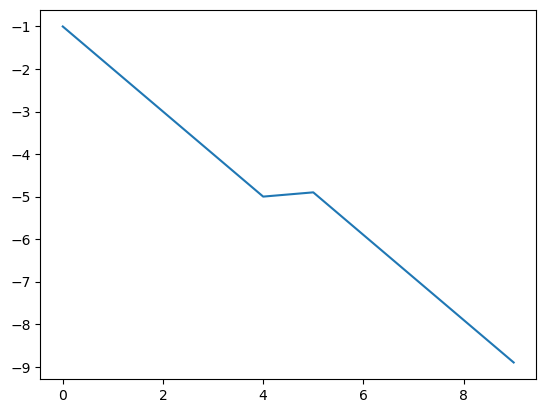

In [22]:
plt.plot(np.cumsum(rewards))

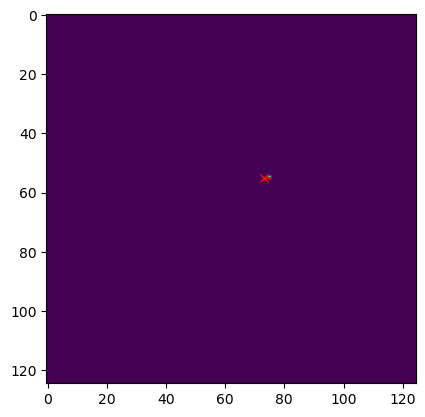

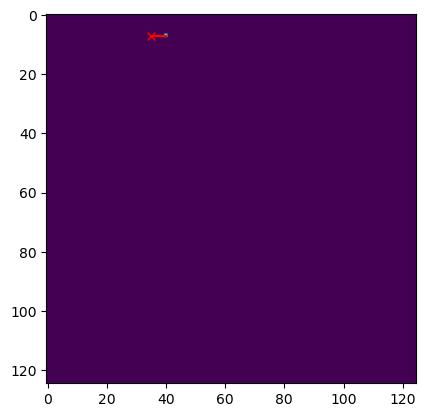

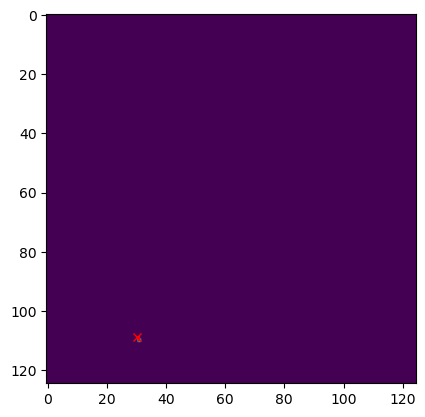

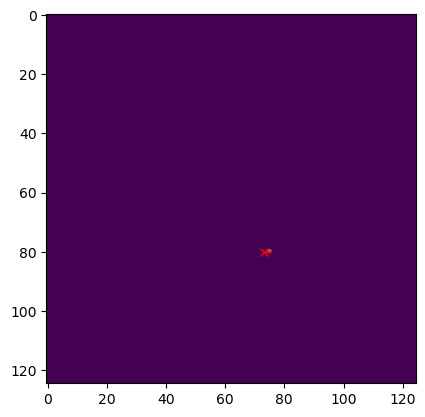

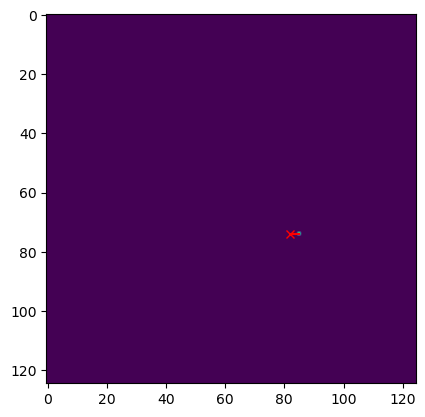

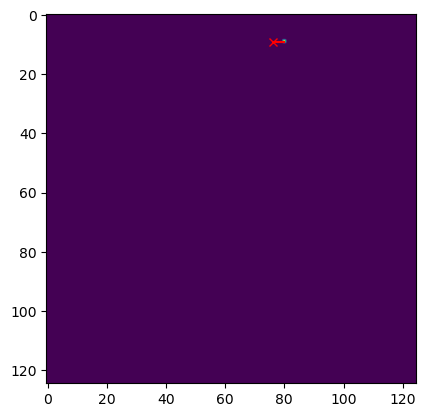

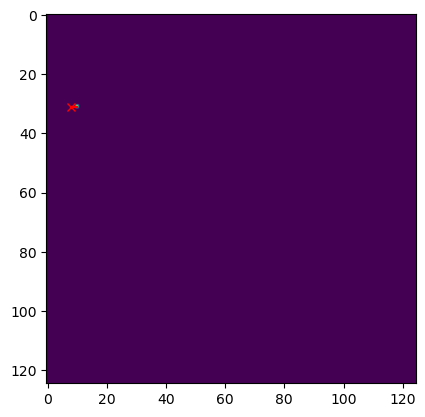

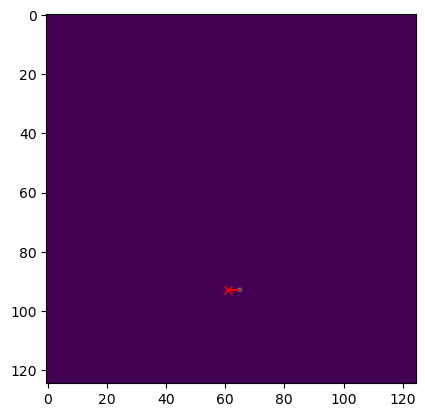

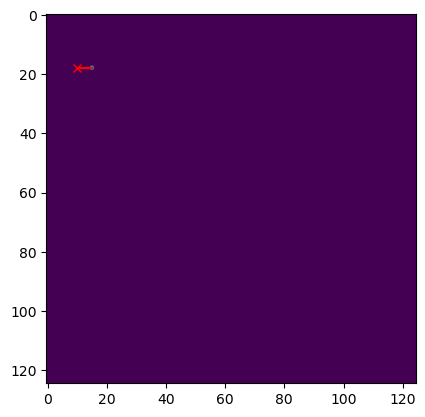

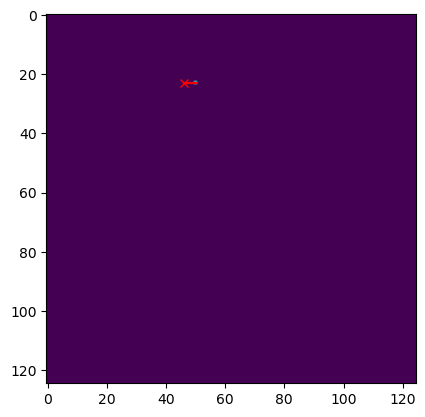

In [20]:
for i in range(10):
    mango.reset_env()
    mango.handle_option(1,1)
    mango.render()
    plt.show()